In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm
from massimal import hyspec_cnn, image_render, annotation
import json

In [2]:
# Paths
pca_im_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v1/train_val')
pca_tile_dir = Path('/home/mha114/data/massimal/vega_sola/hyperspec/datasets/pca_images/pca_images_log_rrs_v1/train_val_tiles')
pca_tile_dir.mkdir(parents=True,exist_ok=True)
class_index_json = Path("/home/mha114/data/massimal/vega_sola/hyperspec/annotation/v2.1/png_gray/label_classes.json")
class_hierarchy_json = Path("/home/mha114/code/github/massimal/annotation/massimal_annotation_class_hierarchy.json")

In [3]:
# Disable GPUs (avoid out of memory error while constructing dataset)
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'
print(f'{visible_devices=}')
print(f'{tf.version.VERSION=}')

visible_devices=[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
tf.version.VERSION='2.8.0'


In [4]:
# Load and print annotation classes 
class_indices = annotation.read_hasty_metadata(class_index_json)

In [5]:
# Load class hierarchy
with open(class_hierarchy_json,'r') as file:
    class_hierarchy = json.load(file)

In [6]:
# Define grouped classes
grouped_classes = ['Sand','Bedrock','Cobble','Maerl','Rockweed','Kelp','Chorda filum']
grouped_class_indices = annotation.class_indices_from_hierarchy(class_hierarchy,class_indices,grouped_classes)
grouped_class_indices['Brown algae (deep)'] = {class_indices['Brown algae']}
print(grouped_class_indices)
print([k for k in grouped_class_indices.keys()])

{'Sand': {9}, 'Bedrock': {4}, 'Cobble': {6}, 'Maerl': {33}, 'Rockweed': {19, 20, 21, 22, 23, 24, 25, 26, 27}, 'Kelp': {13, 14, 15, 16, 17, 18}, 'Chorda filum': {29}, 'Brown algae (deep)': {12}}
['Sand', 'Bedrock', 'Cobble', 'Maerl', 'Rockweed', 'Kelp', 'Chorda filum', 'Brown algae (deep)']


In [7]:
def extract_pca_tiles(dataset_dir_path, grouped_class_indices):
    TILE_SHAPE = (128,128)
    dataset_paths = sorted([path for path in dataset_dir_path.glob('*')])
    
    tiles_dataset_list = []
    
    for dataset_path in tqdm.tqdm(dataset_paths):
        dataset = tf.data.experimental.load(str(dataset_path))

        # Load data
        pca_im, label_im = [numpy_data for numpy_data in dataset.as_numpy_iterator()][0]
        
        # Group classes into smaller number of "superclasses"
        group_label_im, group_indices = annotation.class_map_for_grouped_indices(
            label_im, grouped_class_indices)
        assert np.all(group_label_im>=0)
        assert np.all(group_label_im <= len(grouped_class_indices))
        
        # Split into tiles
        pca_tiles, label_tiles = hyspec_cnn.labeled_image_to_tensor_tiles(pca_im,group_label_im,TILE_SHAPE)

        # Create dataset from tiles
        if len(pca_tiles) > 0: # Some times no tiles are returned, skip these cases
            tile_image_names = tf.convert_to_tensor([dataset_path.name.split('-')[0] for _ in range(len(pca_tiles))])
            tiles_dataset_list.append(tf.data.Dataset.from_tensor_slices((pca_tiles,label_tiles,tile_image_names)))

    # Concatenate tiles
    tiles_concat = tiles_dataset_list[0]
    for i,tiles in enumerate(tiles_dataset_list[1:]):
        try:
            tiles_concat = tiles_concat.concatenate(tiles)
        except Exception as e:
            print(f'Error at tile batch {i}:')
            print(tiles)
            print(e)
    return tiles_concat

In [8]:
# Extract tiles
tiles_dataset = extract_pca_tiles(pca_im_dir,grouped_class_indices)

100%|██████████| 73/73 [00:09<00:00,  7.39it/s]


In [9]:
print(f'Number of tiles: {int(tiles_dataset.cardinality())}')

Number of tiles: 4526


In [10]:
# Save tiles
tf.data.experimental.save(tiles_dataset,path=str(pca_tile_dir / 'vega_sola_log_rrs_pca5_tiles'))

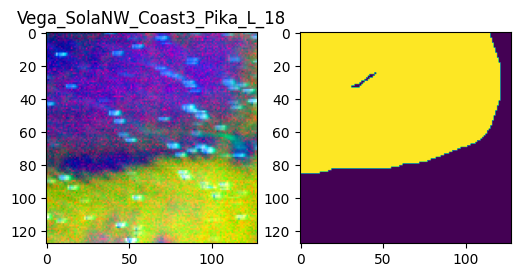

[0 2]


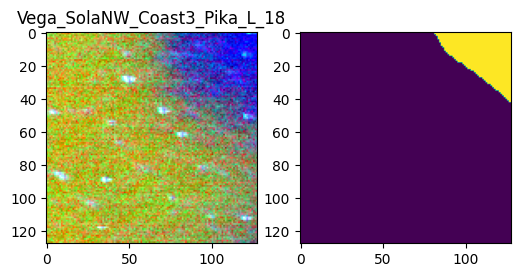

[0 1]


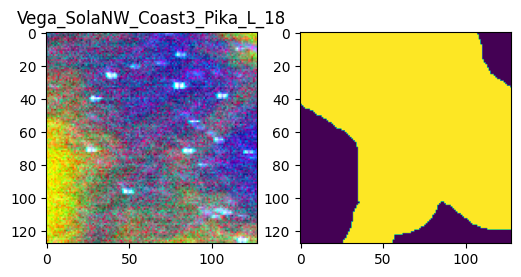

[0 1]


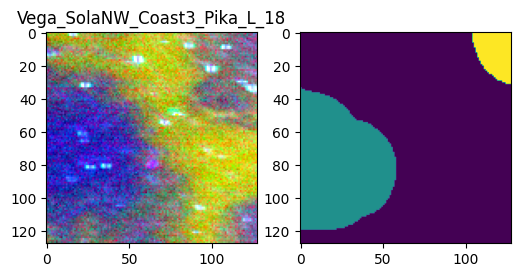

[0 1 2]


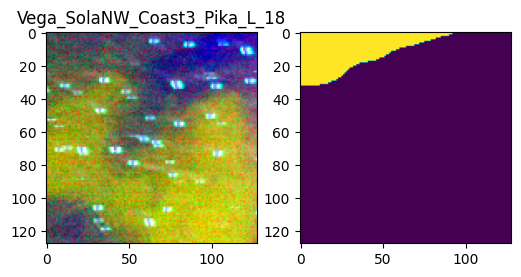

[0 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


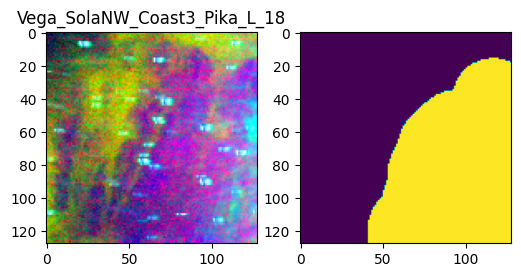

[0 2]


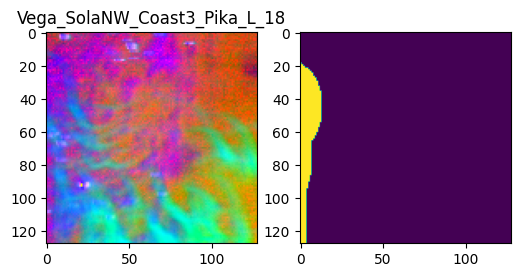

[0 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


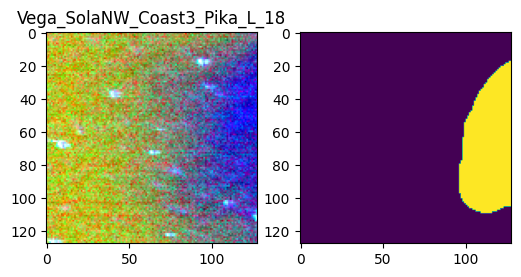

[0 1]


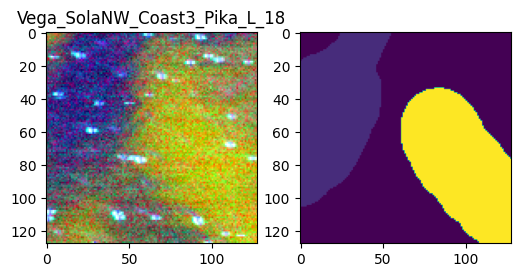

[0 1 8]


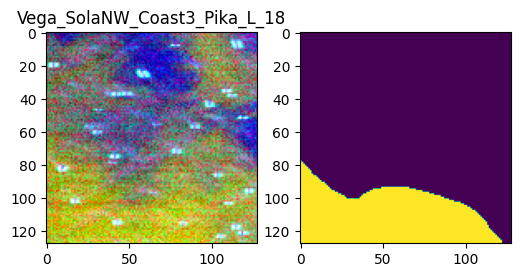

[0 8]


In [11]:
# Plot example tiles and labels.
for pca_tile, label_tile, im_name in tiles_dataset.skip(2000).take(10).as_numpy_iterator():
    fig,ax = plt.subplots(ncols=2,figsize=(6,4))
    ax[0].imshow(image_render.percentile_stretch(pca_tile[:,:,(2,1,0)]))
    ax[1].imshow(label_tile)
    ax[0].set_title(tf.compat.as_str(im_name))
    plt.show()
    print(np.unique(label_tile))

In [13]:
# Check that tile labels are within correct range
tile_labels_unique = set()
for _, label_tile, _ in tiles_dataset.as_numpy_iterator():
    for label in np.unique(label_tile):
        tile_labels_unique.add(label)
print(f'All unique tile labels: {tile_labels_unique}')
assert tile_labels_unique == {0, 1, 2, 3, 4, 5, 6, 7, 8}

All unique tile labels: {0, 1, 2, 3, 4, 5, 6, 7, 8}
